In [1]:
import datetime
import json
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentEncoder
from qiskit_research.mzm_generation import (
    KitaevHamiltonianExperiment,
    KitaevHamiltonianExperimentParameters,
)
from qiskit_research.mzm_generation.utils import transpile_circuit
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations

from qiskit.circuit.library import RZGate
from qiskit_research.utils.dynamical_decoupling import get_instruction_durations

In [2]:
# get backend

# uncomment to use hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend_name = 'ibm_washington'

# Aer simulator backend
# provider = None
# backend_name = "aer_simulator"

In [24]:
# experiment parameters
n_modes = 15
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = list(np.linspace(0.0, 3.0, num=5))
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=2))
# dynamical_decoupling_sequences = None
dynamical_decoupling_sequences=[None, 'X2pm', 'XY4pm', 'XY8pm']
num_dd_passes=1
uhrig_spacing = False
concat_layers = 1
shots = 10000
readout_calibration_shots = 10000

# pick qubits
qubits, backend_name, error_score = pick_qubit_layout(n_modes, backend_name, provider)
print(f"Using qubits {qubits}.")

# date
date = datetime.datetime.now().isoformat()

# create experiment
params = KitaevHamiltonianExperimentParameters(
    timestamp=date,
    backend_name=backend_name,
    qubits=qubits,
    n_modes=n_modes,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=dynamical_decoupling_sequences,
    num_dd_passes=num_dd_passes,
    uhrig_spacing=uhrig_spacing,
    concat_layers=concat_layers,
    seed=11364,
)
experiment = KitaevHamiltonianExperiment(params, provider)

print(f"Total number of circuits: {len(experiment.circuits())}")

Using qubits [16, 26, 27, 28, 29, 30, 31, 32, 36, 51, 50, 49, 48, 47, 35].
Total number of circuits: 3960


In [25]:
%%time

# schedule readout calibration
print("Scheduling readout calibration ...")
mit = mthree.M3Mitigation(experiment.backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots, async_cal=True)

# schedule experiment jobs
print(f"Scheduling experiment ...")
# limit number of circuits per job to avoid timeouts
experiment.backend.configuration().max_experiments = 300
data = experiment.run(shots=shots)
if provider:
    # this only works if the Qiskit Experiments database service is available
    data.save()

# save readout calibration
filename = f"data/readout_calibration/{experiment.backend.name()}/{date}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f"Waiting for readout calibration data ...")
mit.cals_to_file(filename)
print(f"Readout calibration saved.")

# data.block_for_results()

# # save data
# filename = f"data/{params.backend_name}/{params.filename}.json"
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, "w") as f:
#     json.dump(data, f, cls=ExperimentEncoder)

# print(params.filename)

Scheduling readout calibration ...
Scheduling experiment ...


Experiment cannot be saved because no experiment service is available. An experiment service is available, for example, when using an IBM Quantum backend.


Waiting for readout calibration data ...
Readout calibration saved.
CPU times: user 29min 44s, sys: 24min 14s, total: 53min 58s
Wall time: 2h 12min 7s


In [27]:
print(experiment.backend.configuration().timing_constraints['pulse_alignment'])

1


In [36]:
experiment.backend.configuration().dt

2.2222222222222221e-10

In [27]:
data.block_for_results()

# save data
filename = f"data/{params.backend_name}/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

account._job_result_object_storage:WARNING:2022-06-09 19:43:37,292: An error occurred while sending download completion acknowledgement: "('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))"
Adding data from job failed [Job ID: 62a207a2093325731e38a4d5]
Adding data from job failed [Job ID: 62a2077b9262c6fddda35372]


KeyboardInterrupt: 

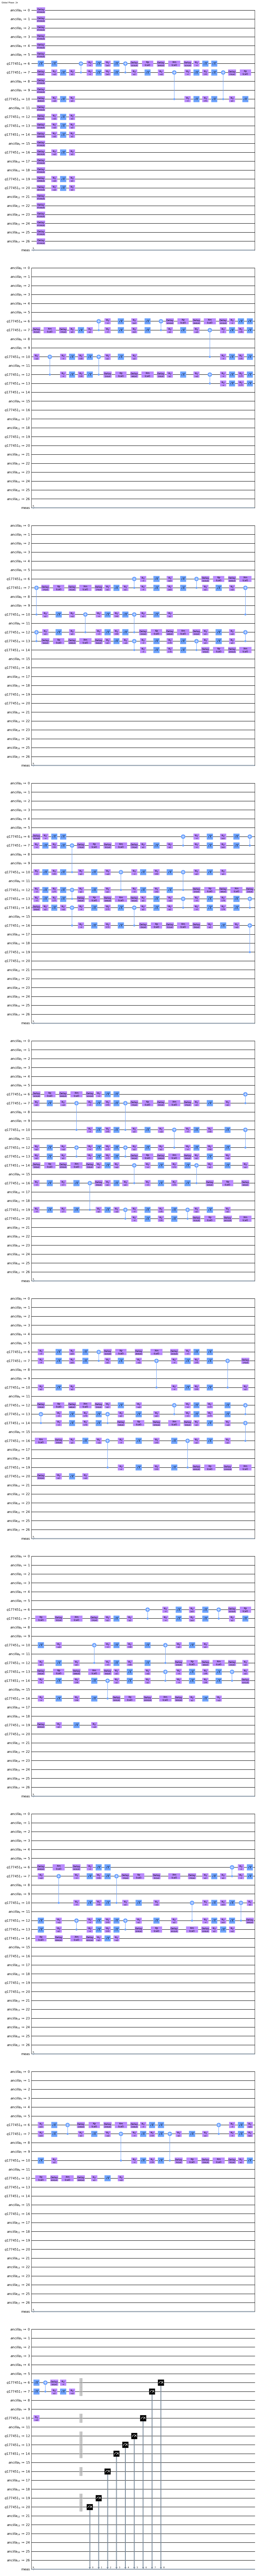

In [35]:









''